In [1]:
%run startup.py

In [2]:
plt.style.use('bmh')

### Read the data

(500, 5)


,open,high,low,close,volume
dt1,,,,,
2022-10-17 11:00:00,"1,319.45","1,325.91","1,314.49","1,317.41","27,144.25"
2022-10-17 12:00:00,"1,317.41","1,322.85","1,313.73","1,319.53","18,657.15"
2022-10-17 13:00:00,"1,319.52","1,324.59","1,319.13","1,323.26","10,240.90"


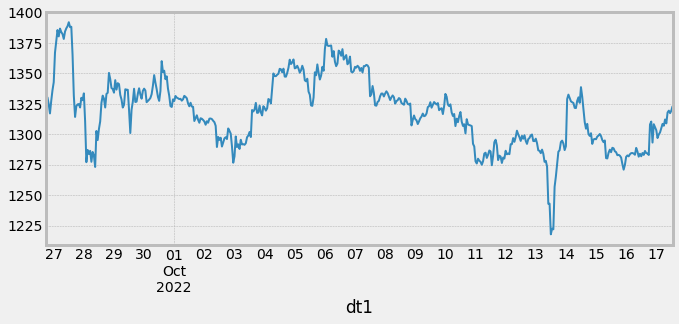

In [3]:
# get the data
url = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
df = pd.read_json(url)
df.columns = ['dt1','open','high','low','close','volume']
# convert to UTC+0
a = [dt.fromtimestamp(x/1000) - relativedelta(hours=6) for x in df.dt1]
df['dt1'] = a
df.to_csv('data/ETH_USDT_free.csv', index = False)
df.set_index('dt1', inplace = True)

print(df.shape)
display(df[-3:])

_ = df['close'].plot(figsize = (10,4))

### Models

In [4]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

In [16]:
day = 16
holdout = 0
x  = df.close[:f'2022-10-{day}'][:-holdout] if holdout > 0 else df.close[:f'2022-10-{day}']
xv = df.close[f'2022-10-{day}':f'2022-10-{day}']

In [24]:
# last value
x_pred = [x[-1]]*24
ts_metrics(xv,x_pred)

{'mae': 18.322083333333364,
 'mse': 393.5449791666683,
 'mape': 0.014262899437226896,
 'smape': 0.014145299397754154,
 'nmse': 0.000237073077516751}

In [33]:
# prophet model
from prophet import Prophet
def get_prophet(x,xv):
    # 1) prepare dataframe
    x = x.reset_index()
    x.columns = ['ds','y']

    # 2) build model
    m = Prophet(weekly_seasonality=True, daily_seasonality=True)
    m.fit(x)

    # # 3) predict
    t1 = 50
    df1 = m.make_future_dataframe(periods=t1, freq='h')
    df_out = m.predict(df1).set_index('ds')['yhat'][xv.index]

    return df_out

In [35]:
x_pred = get_prophet(x,xv)
x_pred

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


dt1
2022-10-16 00:00:00   1,285.53
2022-10-16 01:00:00   1,286.89
2022-10-16 02:00:00   1,287.82
2022-10-16 03:00:00   1,287.87
2022-10-16 04:00:00   1,287.32
2022-10-16 05:00:00   1,286.86
2022-10-16 06:00:00   1,287.00
2022-10-16 07:00:00   1,287.58
2022-10-16 08:00:00   1,287.96
2022-10-16 09:00:00   1,287.66
2022-10-16 10:00:00   1,286.80
2022-10-16 11:00:00   1,286.00
2022-10-16 12:00:00   1,285.83
2022-10-16 13:00:00   1,286.33
2022-10-16 14:00:00   1,287.08
2022-10-16 15:00:00   1,287.59
2022-10-16 16:00:00   1,287.75
2022-10-16 17:00:00   1,287.76
2022-10-16 18:00:00   1,287.81
2022-10-16 19:00:00   1,287.80
2022-10-16 20:00:00   1,287.51
2022-10-16 21:00:00   1,286.97
2022-10-16 22:00:00   1,286.63
2022-10-16 23:00:00   1,287.01
Name: yhat, dtype: float64

In [36]:
ts_metrics(xv,x_pred)

{'mae': 6.348361341753379,
 'mse': 85.29005329206309,
 'mape': 0.004893168728360683,
 'smape': 0.004912382522323686,
 'nmse': 5.137907097260624e-05}

<AxesSubplot:xlabel='dt1'>

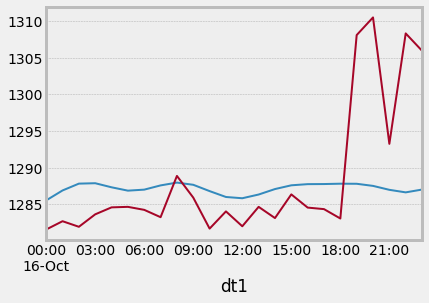

In [38]:
x_pred.plot()
xv.plot()

### prophet

In [4]:
def ts_predict_prophet(df, t1 = 50):
    from prophet import Prophet

    def _predict_prophet(x):
        # 1) prepare dataframe 
        x = x.reset_index()
        x.columns = ['ds','y']

        # 2) build model
        m = Prophet(daily_seasonality=True)
        # m.add_seasonality(name='monthly', period=20.5, fourier_order=5)
        # m.add_regressor('Cl_lr')
        m.fit(x)

        # 3) predict
        df = m.make_future_dataframe(periods=t1, freq='h')
        out = m.predict(df).set_index('ds')['yhat']
        return out

    return df.apply(_predict_prophet, axis = 0)


### exponential smoothing

In [8]:
def ts_predict_exponential(df, t1 = 50):
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
    
    def _predict_exponential(x):
        mean_val = x.mean()
        model = ExponentialSmoothing(x, trend="add", seasonal="add", seasonal_periods=24*7, 
                                     use_boxcox=True, damped = False, initialization_method = 'estimated')

        fit1 = model.fit()
        pred1 = fit1.forecast(x.shape[0] + t1)
        pred1.index = list(x.index) + list(pd.date_range(x.index[-1], periods = t1+1, freq = 'h'))[1:]
        return pred1

    return df.apply(_predict_exponential, axis = 0)

In [9]:
df1 = ts_predict_exponential(df)

C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\abess\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information w

In [10]:
# df1 = df1 + (df.mean() - df1.mean())

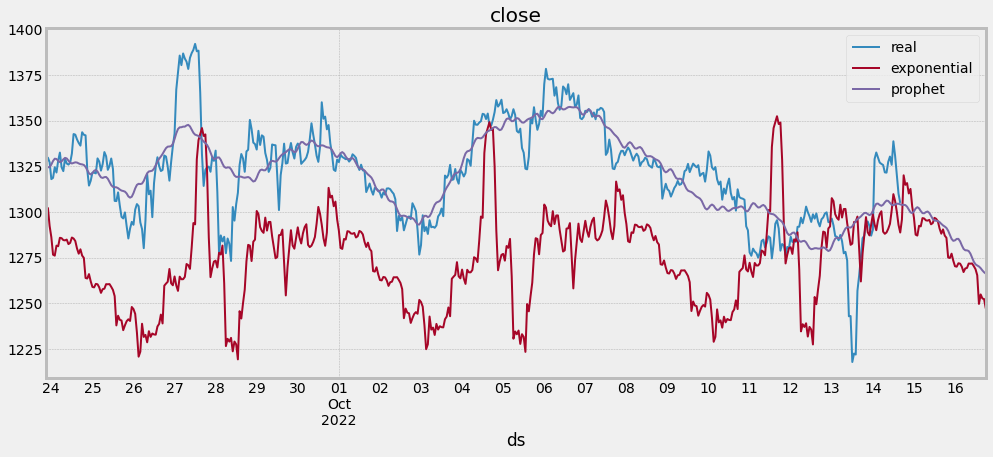

In [12]:
feat = 'close'
_ = df[feat].plot(title = feat, figsize = (15,6))
_ = df1[feat].plot()
_ = df2[feat].plot()

_ = _.legend(['real','exponential','prophet'])